# 02.3 RCT Analysis: The Online Classroom Study

**Chapter**: 2 - Randomised Experiments  
**Section**: 3 - RCT Analysis  
**Facure Source**: 02-Randomised-Experiments.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Online Learning Question](#11-the-online-learning-question)
   - 1.2 [Balance Checks](#12-balance-checks)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Inference for ATE](#21-inference-for-ate)
   - 2.2 [Hypothesis Testing](#22-hypothesis-testing)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Analyzing the Classroom Data](#31-analyzing-the-classroom-data)
   - 3.2 [Statistical Significance](#32-statistical-significance)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy import stats

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Analyzing real RCT data is a common interview task. You should be able to estimate effects, check balance, and interpret results correctly.

### 1.1 The Online Learning Question

Facure's question: **Does online learning affect academic performance?**

Context (2020 pandemic): Schools shifted to online learning. Is this good or bad for students?

**The data**: Alpert, Couch, and Harmon (2016) randomized students into:
1. Face-to-face instruction
2. Online only
3. Blended format

Outcome: Standardized exam score at semester end.

### 1.2 Balance Checks

Before estimating effects, check that randomization worked:
- Are covariates similar across treatment groups?
- Large imbalances suggest problems (but can happen by chance)

★ Insight ─────────────────────────────────────
- Balance checks are a sanity check, not a requirement
- Small imbalances are expected (randomization noise)
- Large imbalances suggest implementation problems
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Inference for ATE

**Point estimate** (difference in means):
$$\hat{\tau} = \bar{Y}_1 - \bar{Y}_0$$

**Standard error** (Neyman, 1923):
$$\widehat{SE}(\hat{\tau}) = \sqrt{\frac{s_1^2}{n_1} + \frac{s_0^2}{n_0}}$$

where $s_t^2$ is the sample variance in group $t$.

**Confidence interval** (asymptotic):
$$\hat{\tau} \pm z_{\alpha/2} \cdot \widehat{SE}(\hat{\tau})$$

For 95% CI, $z_{0.025} \approx 1.96$.

### 2.2 Hypothesis Testing

**Null hypothesis**: $H_0: \tau = 0$ (no treatment effect)

**Test statistic**:
$$t = \frac{\hat{\tau} - 0}{\widehat{SE}(\hat{\tau})}$$

**Decision rule** (two-sided, $\alpha = 0.05$):
- Reject $H_0$ if $|t| > 1.96$
- Or equivalently, if CI excludes 0

**P-value**: Probability of observing $|t|$ this extreme under $H_0$.

| Quantity | Formula | Interpretation |
|----------|---------|----------------|
| Point estimate | $\bar{Y}_1 - \bar{Y}_0$ | Best guess of ATE |
| Standard error | $\sqrt{s_1^2/n_1 + s_0^2/n_0}$ | Uncertainty in estimate |
| 95% CI | $\hat{\tau} \pm 1.96 \cdot SE$ | Range of plausible values |
| P-value | $2 \cdot P(|Z| > |t|)$ | Evidence against null |

---

## 3. Numeric Demonstration

### 3.1 Analyzing the Classroom Data

In [2]:
# Load the online classroom data
data = load_facure_data('online_classroom.csv')

print("ONLINE CLASSROOM STUDY")
print("="*50)
print(f"Sample size: n = {len(data)}")
print(f"\nColumns: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

ONLINE CLASSROOM STUDY
Sample size: n = 323

Columns: ['gender', 'asian', 'black', 'hawaiian', 'hispanic', 'unknown', 'white', 'format_ol', 'format_blended', 'falsexam']

First few rows:


,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0,0.0000,63.3000
1,1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0,0.0000,79.9600
2,1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0,1.0000,83.3700
3,1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0,1.0000,90.0199
4,1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1,0.0000,83.3000


In [3]:
# Create treatment variable
data['class_format'] = np.select(
    [data['format_ol'].astype(bool), data['format_blended'].astype(bool)],
    ['online', 'blended'],
    default='face_to_face'
)

# Summary by treatment group
summary = data.groupby('class_format').agg({
    'falsexam': ['mean', 'std', 'count'],
    'gender': 'mean',  # Proportion female
}).round(2)

print("SUMMARY BY TREATMENT GROUP")
print("="*60)
print(summary)

SUMMARY BY TREATMENT GROUP
             falsexam               gender
                 mean     std count   mean
class_format                              
blended       77.0900 10.0900   109 0.5500
face_to_face  78.5500  9.5600   120 0.6300
online        73.6400 14.9000    94 0.5400


In [4]:
# Balance check: Are covariates similar across groups?
covariates = ['gender', 'asian', 'black', 'hispanic', 'white']

print("BALANCE CHECK")
print("="*60)
print(f"{'Covariate':<15} {'Face-to-Face':>12} {'Online':>12} {'Blended':>12} {'SMD (Onl)':>10}")
print("-"*60)

for cov in covariates:
    means = data.groupby('class_format')[cov].mean()
    pooled_sd = data[cov].std()
    smd = (means['online'] - means['face_to_face']) / pooled_sd if pooled_sd > 0 else 0
    print(f"{cov:<15} {means['face_to_face']:>12.3f} {means['online']:>12.3f} "
          f"{means['blended']:>12.3f} {smd:>+10.3f}")

print("-"*60)
print("SMD < 0.1 suggests good balance (rule of thumb)")

BALANCE CHECK
Covariate       Face-to-Face       Online      Blended  SMD (Onl)
------------------------------------------------------------
gender                 0.633        0.543        0.550     -0.184
asian                  0.202        0.229        0.218     +0.065
black                  0.071        0.029        0.103     -0.166
hispanic               0.010        0.029        0.013     +0.146
white                  0.717        0.700        0.628     -0.037
------------------------------------------------------------
SMD < 0.1 suggests good balance (rule of thumb)


In [5]:
# Focus on online vs face-to-face comparison
online = data.query('class_format == "online"')['falsexam']
face_to_face = data.query('class_format == "face_to_face"')['falsexam']

# Point estimate
ate = online.mean() - face_to_face.mean()

# Standard error (Neyman formula)
se = np.sqrt(online.var() / len(online) + face_to_face.var() / len(face_to_face))

# Confidence interval
ci_low = ate - 1.96 * se
ci_high = ate + 1.96 * se

# T-statistic and p-value
t_stat = ate / se
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

print("ATE ESTIMATION: Online vs Face-to-Face")
print("="*50)
print(f"E[Score | Online]      = {online.mean():.2f}")
print(f"E[Score | Face-to-Face] = {face_to_face.mean():.2f}")
print(f"\nATE = {ate:.2f}")
print(f"SE  = {se:.2f}")
print(f"95% CI = [{ci_low:.2f}, {ci_high:.2f}]")
print(f"\nT-statistic = {t_stat:.2f}")
print(f"P-value     = {p_value:.4f}")
print(f"\nStatistically significant at α=0.05? {p_value < 0.05}")

ATE ESTIMATION: Online vs Face-to-Face
E[Score | Online]      = 73.64
E[Score | Face-to-Face] = 78.55

ATE = -4.91
SE  = 1.77
95% CI = [-8.38, -1.45]

T-statistic = -2.78
P-value     = 0.0054

Statistically significant at α=0.05? True


### 3.2 Statistical Significance

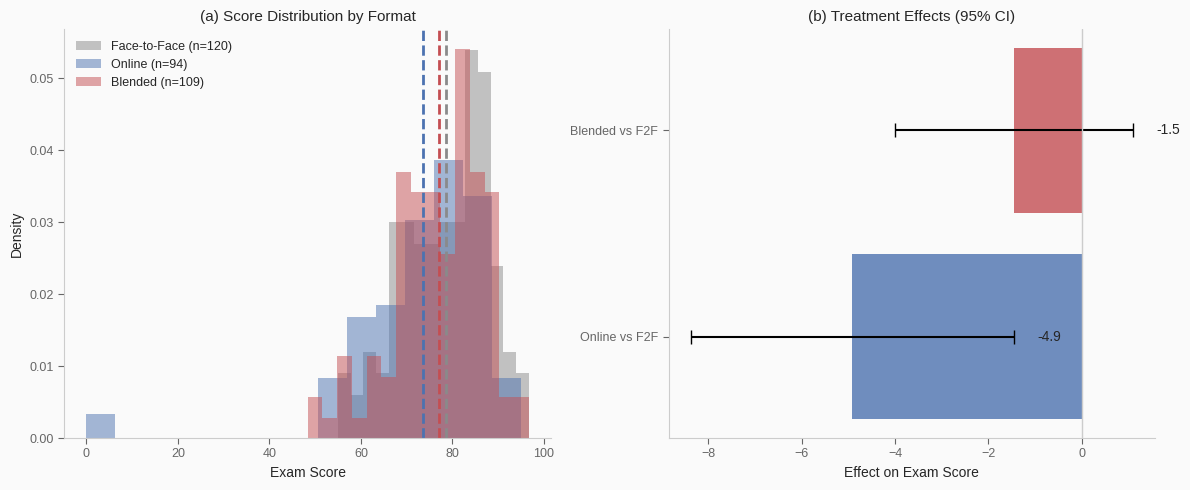

In [6]:
# Visualize results
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Distribution by group
ax = axes[0]
groups = ['face_to_face', 'online', 'blended']
colors = [TUFTE_PALETTE['control'], TUFTE_PALETTE['treatment'], TUFTE_PALETTE['effect']]
labels = ['Face-to-Face', 'Online', 'Blended']

for group, color, label in zip(groups, colors, labels):
    subset = data.query(f'class_format == "{group}"')['falsexam']
    ax.hist(subset, bins=15, alpha=0.5, label=f'{label} (n={len(subset)})', 
            color=color, density=True)
    ax.axvline(subset.mean(), color=color, linestyle='--', linewidth=2)

ax.set_xlabel('Exam Score')
ax.set_ylabel('Density')
ax.set_title('(a) Score Distribution by Format')
ax.legend(frameon=False)

# Panel 2: Effect estimates with CI
ax = axes[1]

# Calculate effects for each comparison
comparisons = [
    ('Online vs F2F', 
     data.query('class_format == "online"')['falsexam'],
     data.query('class_format == "face_to_face"')['falsexam']),
    ('Blended vs F2F', 
     data.query('class_format == "blended"')['falsexam'],
     data.query('class_format == "face_to_face"')['falsexam']),
]

effects = []
for name, treat, ctrl in comparisons:
    effect = treat.mean() - ctrl.mean()
    se_eff = np.sqrt(treat.var()/len(treat) + ctrl.var()/len(ctrl))
    effects.append((name, effect, se_eff))

y_pos = np.arange(len(effects))
ax.barh(y_pos, [e[1] for e in effects], 
        xerr=[1.96 * e[2] for e in effects],
        color=[TUFTE_PALETTE['treatment'], TUFTE_PALETTE['effect']],
        alpha=0.8, capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels([e[0] for e in effects])
ax.axvline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.set_xlabel('Effect on Exam Score')
ax.set_title('(b) Treatment Effects (95% CI)')

# Annotate
for i, (name, effect, se_eff) in enumerate(effects):
    ax.text(effect + 1.96*se_eff + 0.5, i, f'{effect:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
# Regression-based inference (equivalent, but gives more diagnostics)
import statsmodels.formula.api as smf

# Binary comparison: online vs face-to-face
data_binary = data.query('class_format != "blended"').copy()
data_binary['online'] = (data_binary['class_format'] == 'online').astype(int)

model = smf.ols('falsexam ~ online', data=data_binary).fit()

print("REGRESSION OUTPUT")
print("="*60)
print(model.summary().tables[1])

REGRESSION OUTPUT
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.5475      1.113     70.563      0.000      76.353      80.742
online        -4.9122      1.680     -2.925      0.004      -8.223      -1.601


In [8]:
# Verify regression matches our manual calculation
print("\nVERIFICATION")
print("="*50)
print(f"Manual ATE:       {ate:.4f}")
print(f"Regression coef:  {model.params['online']:.4f}")
print(f"Match: {np.isclose(ate, model.params['online'], rtol=1e-6)}")


VERIFICATION
Manual ATE:       -4.9122
Regression coef:  -4.9122
Match: True


---

## 4. Implementation

Complete RCT analysis workflow:

```python
from causal_inference.rct import simple_ate, balance_check
from causal_inference.diagnostics import covariate_balance_plot

# Step 1: Balance check
balance = balance_check(
    covariates=data[['gender', 'asian', 'black', 'hispanic', 'white']],
    treatment=data['online']
)
print(balance.summary())  # Check SMD < 0.1

# Step 2: Estimate ATE
result = simple_ate(
    outcome=data['falsexam'],
    treatment=data['online'],
    confidence_level=0.95
)

print(f"ATE: {result.ate:.2f}")
print(f"SE:  {result.se:.2f}")
print(f"CI:  [{result.ci_lower:.2f}, {result.ci_upper:.2f}]")
print(f"P-value: {result.p_value:.4f}")

# Step 3: Visualize
covariate_balance_plot(balance)
result.plot_effect()  # Forest plot with CI
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Airbnb Staff, DS)**: *"You ran an A/B test and got a p-value of 0.03. What does this mean, and what would you conclude?"*

<details>
<summary>Solution</summary>

**What p-value = 0.03 means**:
- If there were truly no effect (null hypothesis), we'd see a result this extreme only 3% of the time
- It does NOT mean there's a 97% chance the effect is real

**What I would conclude**:

1. **Statistically significant at α = 0.05**: p < 0.05, so we reject the null.

2. **But consider practical significance**:
   - How large is the effect?
   - Is it meaningful for the business?

3. **Check for multiple testing**:
   - Did we run many tests?
   - Need Bonferroni or similar correction

4. **Look at confidence interval**:
   - How wide is the CI?
   - Does it include effects too small to care about?

5. **Consider power**:
   - Was the sample large enough?
   - Underpowered tests often give unreliable estimates

**Never conclude**: "There's a 97% chance the treatment works." (Common misinterpretation)

</details>

---

**Q2 (Meta E5, Applied Scientist)**: *"How would you analyze an A/B test with three treatment arms?"*

<details>
<summary>Solution</summary>

**Option 1: Pairwise comparisons**
- Compare each treatment to control separately
- Adjust for multiple comparisons (Bonferroni, Holm, etc.)
- Simple but loses power

**Option 2: Regression with dummies**
```python
Y ~ treatment_A + treatment_B  # control is baseline
```
- Coefficients give effect of each vs. control
- F-test for joint significance
- Standard errors account for common control group

**Option 3: ANOVA**
- Test if ANY treatment differs from control
- Follow-up with pairwise tests if significant

**Key considerations**:
1. **Pre-specify comparisons**: Decide before analyzing which comparisons matter
2. **Control for multiplicity**: More arms = more chance of false positives
3. **Check balance for each arm**: Randomization should work separately
4. **Report all comparisons**: Don't cherry-pick significant results

</details>

---

**Q3 (DoorDash L6, Economist)**: *"An A/B test shows the treatment group has significantly different pre-treatment characteristics. What would you do?"*

<details>
<summary>Solution</summary>

**First: Assess the severity**
- How large is the imbalance? (SMD > 0.1 is concerning)
- Is it on important predictors of the outcome?
- Is it likely due to chance or implementation error?

**If likely due to chance (small imbalance)**:
- Continue with analysis
- Use regression adjustment to increase precision
- Report the imbalance transparently

**If likely due to implementation error**:
- Investigate the randomization procedure
- Check for bugs in assignment code
- Consider discarding the experiment

**Adjustment options**:
1. **Regression adjustment** (ANCOVA):
   - Include imbalanced covariate as control
   - Increases precision even in RCTs
   
2. **Stratified analysis**:
   - Analyze within strata of the imbalanced variable
   - Weight by stratum size

3. **Re-randomization**:
   - If caught early, can re-randomize
   - Some designs re-randomize until balance achieved

**What NOT to do**:
- Don't just ignore the imbalance
- Don't selectively report (if adjustment changes results)
- Don't claim the experiment is invalid without investigating

</details>

---

## 6. References

[^1]: Alpert, W. T., Couch, K. A., and Harmon, O. R. (2016). A Randomized Assessment of Online Learning. *American Economic Review*, 106(5), 378-382.

[^2]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 2: "In a School Far, Far Away."

[^3]: Imbens, G. W. and Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press, Chapter 6.

[^4]: Lin, W. (2013). Agnostic Notes on Regression Adjustments to Experimental Data: Reexamining Freedman's Critique. *Annals of Applied Statistics*, 7(1), 295-318.

---

**Precision Improvement:**
- You said: "Build the RCT analysis notebook"
- Concise: "Build 02.3 RCT analysis"
- Precise: `/augmented 02.3 --online-classroom --inference`
- Pattern: [build] [chapter.section] [content-flags]